In [10]:
from ase.io import read
atoms=read('/home/emi/lammps/aSi-1728/relaxed.data',format='lammps-data',style='atomic')

In [11]:
import numpy as np
natom=len(atoms.positions)
nmodes=natom*3
dyn_file='/home/emi/lammps/aSi-1728/Dyn.form'
lammps_dyn=np.loadtxt(dyn_file).reshape((nmodes,nmodes))

In [12]:
eigenvalue, eigenvector=np.linalg.eigh(lammps_dyn)

In [13]:
eigenvalue

array([9.82072892e-05, 1.19146938e-04, 1.35273458e-04, ...,
       1.47320516e+00, 1.49274957e+00, 1.51751320e+00])

In [14]:
#evaluate Fourier component
#100 direction
import numpy as np
def get_C(eigenvector, position,unit_vector, k_vector):
    disp=np.reshape(eigenvector,(natom,3))
    polalization=np.dot(unit_vector, disp.T)
    phase=np.exp(1.0j*np.dot(k_vector, position.T))

    return np.abs(np.dot(polalization, phase))

In [15]:
import pyAF.constants
pc=pyAF.constants.physical_constants()
omega=[]
nmodes=len(eigenvalue)
#extract minimum index of negative frequency
mode_negative=0
for i in range(nmodes):
    if eigenvalue[i] <0.0:
        val=0
        omega.append(val)
        mode_negative=i
    else:
        val=np.sqrt(eigenvalue[i])*pc.scale_THz
        omega.append(val)

In [40]:
kmin=2*np.pi/atoms.cell[0,0]
kmin

0.19136245817894493

In [134]:
def polar_coord_sampling(n_sample,diameter):
    theta=np.linspace(0,np.pi,n_sample,endpoint=False)
    phi=np.linspace(0,2.0*np.pi,n_sample,endpoint=False)
    x=np.array([[diameter*np.sin(t)*np.cos(p) for t in theta] for p in phi]).flatten()
    y=np.array([[diameter*np.sin(t)*np.sin(p) for t in theta] for p in phi]).flatten()
    z=np.array([[diameter*np.cos(t) for t in theta] for p in phi]).flatten()

    return np.stack([x,y,z],axis=1)


In [135]:
sampling=polar_coord_sampling(5,1.0)
sampling.shape

(25, 3)

In [94]:
id=1010
E=omega[id]
unit_vector=[0.0,1.0,0.0]
position=atoms.positions
ev=eigenvector[:,id]

kvec=np.linspace(0.1,1.9,100)
C_T=[]
C_L=[]
for k in kvec:
    k_vector=[k,0,0]
    unit_vector_L=[1.0,0.0,0.0]
    unit_vector_T=[0.0,1.0,0.0]
    C_T.append(get_C(ev,position,unit_vector_T,k_vector))
    C_L.append(get_C(ev,position,unit_vector_L,k_vector))

#THz and meV
E, E*4.13567

(5.14188449032418, 21.265137430099)

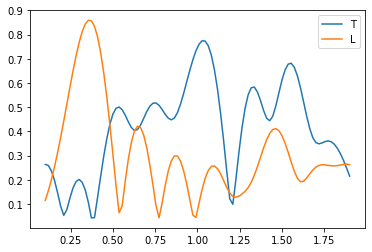

In [95]:
import matplotlib.pyplot as plt
plt.plot(kvec,C_T,label='T')
plt.plot(kvec,C_L,label='L')
plt.legend()


average for k

In [166]:
id=300
n_sample=15
E=omega[id]
position=atoms.positions
ev=eigenvector[:,id]

kvec=np.linspace(0.1,1.9,100)
C_T=[]
C_L=[]
for k in kvec:
    k_vector=polar_coord_sampling(n_sample,k)
    tmp_L=np.zeros(n_sample*n_sample)
    tmp_T=np.zeros(n_sample*n_sample)
    for i,vec in enumerate(k_vector):

        unit_vector_L=vec/np.linalg.norm(vec)
        unit_vector_T=np.array([unit_vector_L[1],-unit_vector_L[0],0])
        tmp_L[i]=get_C(ev,position,unit_vector_L,vec)
        tmp_T[i]=get_C(ev,position,unit_vector_T,vec)
    C_L.append(np.mean(tmp_L))
    C_T.append(np.mean(tmp_T))

#THz and meV
E, E*4.13567

(2.3356163906865186, 9.659338638470516)

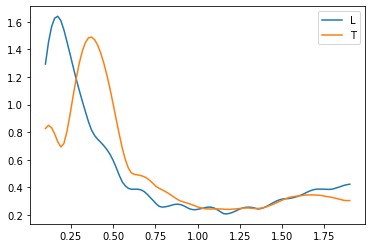

In [167]:
import matplotlib.pyplot as plt
plt.plot(kvec,C_L,label='L')
plt.plot(kvec,C_T,label='T')
plt.legend()